### Setup

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor
from torch import nn

from torch.utils.data import DataLoader,default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

mpl.rcParams['image.cmap'] = 'gray'

### Get data

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

with gzip.open(path_gz, 'rb') as f: 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

### Understanding convolutions

In [3]:
train_imgs = x_train.view(-1, 28, 28)
valid_imgs = x_valid.view(-1, 28, 28)

train_imgs.shape, valid_imgs.shape

(torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]))

<AxesSubplot:>

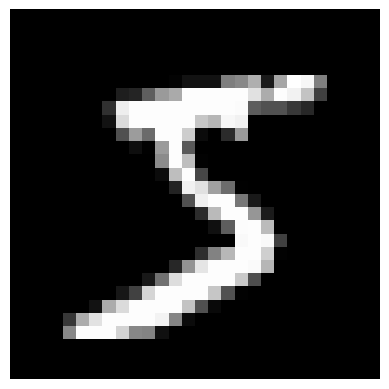

In [4]:
img = train_imgs[0]
show_image(img)

<AxesSubplot:>

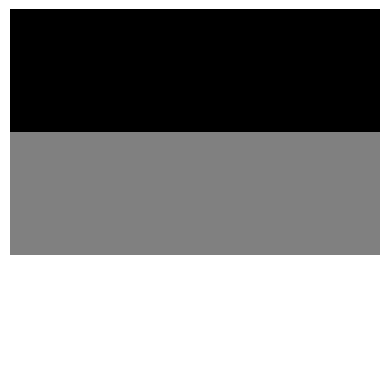

In [5]:
top_edge = tensor(
    [
        [-1,-1,-1],
        [ 0, 0, 0],
        [ 1, 1, 1]
    ]
).float()

show_image(top_edge)

In [6]:
df = pd.DataFrame(img[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
1,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
2,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
3,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
4,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
5,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.0117),tensor(0.0703),tensor(0.0703),tensor(0.0703),tensor(0.4922),tensor(0.5312),tensor(0.6836),tensor(0.1016),tensor(0.6484),tensor(0.9961),tensor(0.9648)
6,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.1172),tensor(0.1406),tensor(0.3672),tensor(0.6016),tensor(0.6641),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.8789),tensor(0.6719),tensor(0.9883),tensor(0.9453),tensor(0.7617)
7,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.1914),tensor(0.9297),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.9805),tensor(0.3633),tensor(0.3203),tensor(0.3203),tensor(0.2188),tensor(0.1523)
8,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.0703),tensor(0.8555),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.9883),tensor(0.7734),tensor(0.7109),tensor(0.9648),tensor(0.9414),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
9,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.3125),tensor(0.6094),tensor(0.4180),tensor(0.9883),tensor(0.9883),tensor(0.8008),tensor(0.0430),tensor(0.),tensor(0.1680),tensor(0.6016),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)


In [7]:
def apply_kernel(img, row, col, kernel):
    return (img[row-1:row+2, col-1:col+2] * kernel).sum()

In [8]:
apply_kernel(img, 5, 9, top_edge)

tensor(0.6250)

<AxesSubplot:>

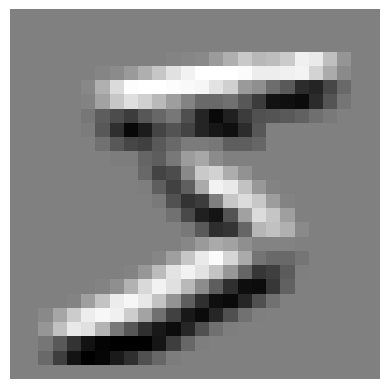

In [9]:
rng = range(1, 27)
top_edge_img = tensor([[apply_kernel(img, i, j, top_edge)for j in rng] for i in rng])
show_image(top_edge_img)

<AxesSubplot:>

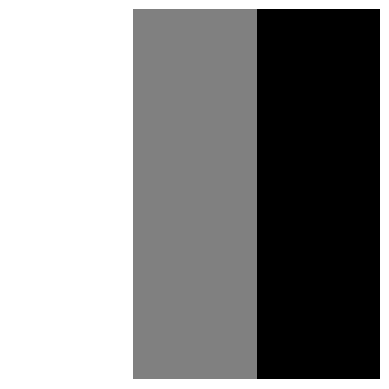

In [10]:
right_edge = tensor(
    [
        [1, 0, -1],
        [1, 0, -1],
        [1, 0, -1]
    ]
).float()

show_image(right_edge)

<AxesSubplot:>

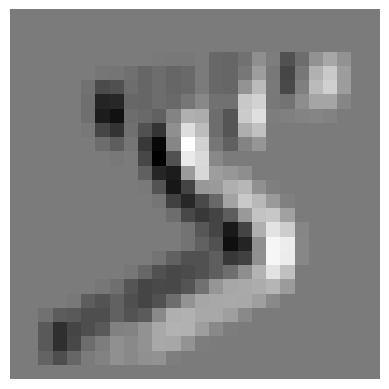

In [11]:
rng = range(1, 27)
right_edge_img = tensor([[apply_kernel(img, i, j, right_edge)for j in rng] for i in rng])
show_image(right_edge_img)

### Convolutions in PyTorch

In [12]:
import torch.nn.functional as F
import torch

In [13]:
inp = img[None, None, :, :].float()
inp.shape

torch.Size([1, 1, 28, 28])

In [14]:
inp_unf = F.unfold(inp, (3,3))
inp_unf.shape

torch.Size([1, 9, 676])

In [15]:
w = right_edge.view(-1)
w.shape

torch.Size([9])

In [16]:
out_unf = w@inp_unf[0]

<AxesSubplot:>

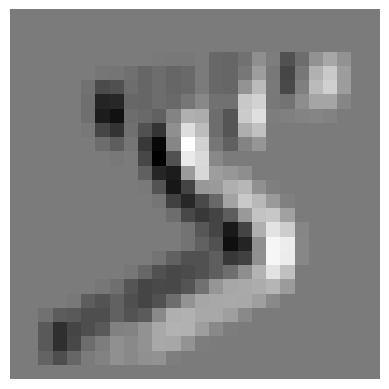

In [17]:
out = out_unf.view(26,26)
show_image(out)

In [18]:
%timeit -n 1 tensor([[apply_kernel(img, i,j,right_edge) for j in rng] for i in rng]);

16.3 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26,26);

83.1 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%timeit -n 100 F.conv2d(inp, right_edge[None,None])

60.5 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<AxesSubplot:>

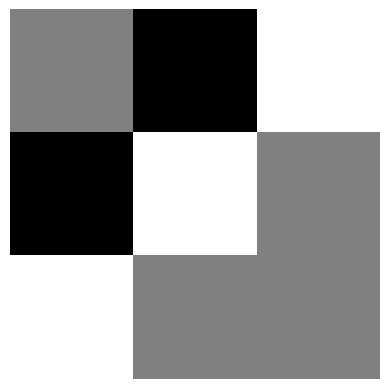

In [21]:
diag1_edge = tensor(
    [
        [0, -1, 1],
        [-1, 1, 0],
        [1, 0, 0]
    ]
).float()

show_image(diag1_edge)

<AxesSubplot:>

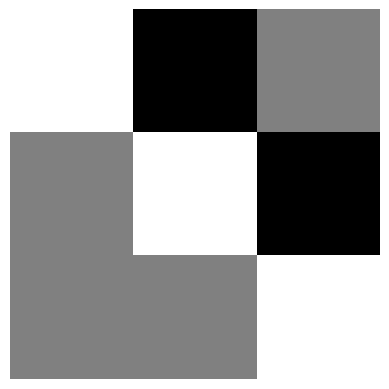

In [22]:
diag2_edge = tensor(
    [
        [1,-1,0],
        [0,1,-1],
        [0,0,1]
    ]
).float()

show_image(diag2_edge)

In [23]:
xb = train_imgs[:16][:, None]
xb.shape

torch.Size([16, 1, 28, 28])

In [24]:
edge_kernels = torch.stack([right_edge, top_edge, diag1_edge, diag2_edge])[:, None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [25]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

<AxesSubplot:>

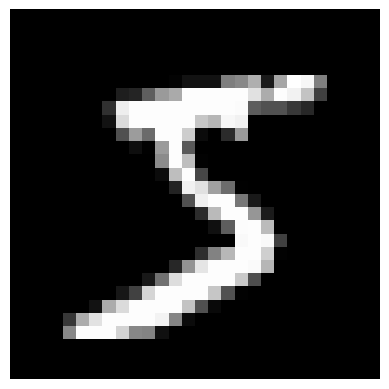

In [26]:
img = xb[0,0]
show_image(img)

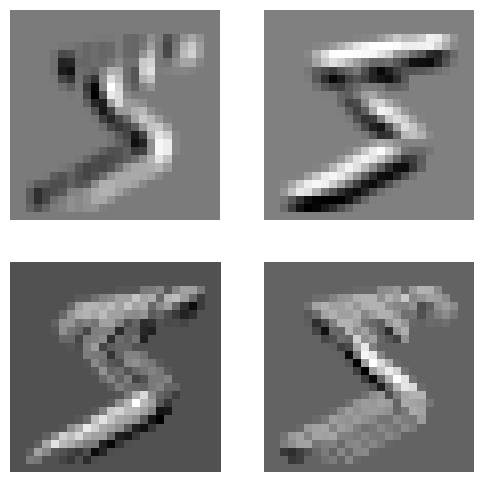

In [27]:
show_images([batch_features[0,i] for i in range(4)])

### Creating a CNN

In [28]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act==True:
        res = nn.Sequential(
            res,
            nn.ReLU()
        )
    return res

In [29]:
simple_cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 10, act=False),
    nn.Flatten(),
)

simple_cnn(xb).shape

torch.Size([16, 10])

In [30]:
train_imgs = x_train.view(-1, 1, 28, 28)
valid_imgs = x_valid.view(-1, 1, 28, 28)
train_ds, valid_ds = Dataset(train_imgs, y_train), Dataset(valid_imgs, y_valid)

In [31]:
device = 'mps' if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

def to_device(x, device):

    if isinstance(x, Mapping):
        return {k:v.to(device) for k,v in x.items}
    
    x_type = type(x)
    return x_type(o.to(device) for o in x)

def collate_device(b):
    return to_device(default_collate(b), device)

In [32]:
from torch import optim

bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [33]:
los, acc = fit(5, simple_cnn, F.cross_entropy, opt, train_dl, valid_dl)

0 1.805612126159668 0.43000000019073487
1 0.22894234461784363 0.9289000004768372
2 0.15318569631576537 0.9526999992370605
3 0.16646970219612123 0.9492999994277954
4 0.09780305001735687 0.970099999332428
